In [4]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers
from keras import utils

### Extracting and preprocessing data

In [5]:
# Input test and train data

trainFolder = "../input/asl-alphabet/asl_alphabet_train/"
testFolder =  "../input/asl-alphabet/asl_alphabet_test/"

# Converst letter to number
def letterToNumber(letter):
    if(len(letter) == 1):
        letterNum = ord(letter.lower()) - 97
    elif(letter == 'del'):
        letterNum = 26
    elif(letter == 'nothing'):
        letterNum = 27
    elif(letter == 'space'):
        letterNum = 28
    else:
        letterNum = 29
    return letterNum
    
# Normalizes the image file and resizes it
def processImageFile(imageFile, isInColor):
    # When the picture is downsized - anti_aliasing is suggested
    if isInColor == 0:
        color = 1
    else:
        color = 3
    resizedImage = resize(imageFile, (50, 50, color), anti_aliasing=True)
    return np.asarray(resizedImage)

# Extracts the data
def extractData(file, isInColor = 0):
    X = []
    y = []
    for folderName in os.listdir(file):
        if not folderName.startswith('.'):
            classLetter = folderName
            classNum = letterToNumber(classLetter)
            fullFolderName = file+folderName
            listOfImages = os.listdir(fullFolderName)
            for imageName in tqdm(listOfImages[0:1000]):
                fullImageName = fullFolderName + "/" + imageName
                imageFile = cv2.imread(fullImageName, isInColor)
                resizedImage = processImageFile(imageFile, isInColor)            
                X.append(resizedImage)
                y.append(classNum)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [11]:
# Extract the data
X, y = extractData(trainFolder)

100%|██████████| 1000/1000 [00:02<00:00, 495.82it/s]


### Saving preprocessed data

In [3]:
np.save("../data/XData", X)
print("XData saved")
np.save("../data/yData", y)
print("yData saved")

NameError: name 'X' is not defined

### Data preview

(50, 50, 3)


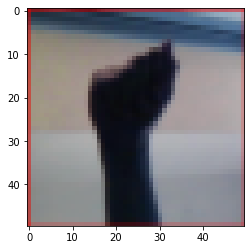

In [10]:
isInColor = 1

testImage = cv2.imread("../input/asl-alphabet/asl_alphabet_train/A/A1.jpg", isInColor)
resizedTestImage = processImageFile(testImage, isInColor)
print(resizedTestImage.shape)
plt.imshow(resizedTestImage, cmap='gray')
plt.show()

### Loading preprocessed data

In [20]:
X = np.load('../data/XData.npy')
y = np.load('../data/yData.npy')

In [12]:
print(X.shape)
print(y.shape)

(29000, 50, 50, 1)
(29000,)


### Preprocess target variable

In [13]:
# One hot encoding of target variable

numOfClasses = 30
y = to_categorical(y, numOfClasses)

### Splitting data

In [14]:
# Splitting data into train and test datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

### Saving test and training datasets

In [24]:
np.save("../data/Xtrain", X_train)
np.save("../data/Xtest", X_test)
print("X saved")
np.save("../data/Ytrain", y_train)
np.save("../data/Ytest", y_test)
print("Y saved")

X saved
Y saved


### Loading test and training datasets

In [25]:
X_train = np.load("../data/Xtrain.npy")
X_test = np.load("../data/Xtest.npy")
print("X loaded")
y_train = np.load("../data/Ytrain.npy")
y_test = np.load("../data/Ytest.npy")
print("Y loaded")

X loaded
Y loaded


In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(19430, 50, 50, 3)
(9570, 50, 50, 3)
(19430, 30)
(9570, 30)


### Model making

In [32]:
# DOBAR MODEL ZA COLOR 
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(numOfClasses, activation='softmax'))

In [15]:
# DOBAR MODEL ZA GRAYSCALE
model = Sequential()
model.add(Conv2D(16, (2,2), input_shape=(50,50,1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(3, 3), padding='same'))
model.add(Conv2D(64, (5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(5, 5), strides=(5, 5), padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(numOfClasses, activation='softmax'))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 49, 49, 16)        80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)               

In [17]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [18]:
batch_size = 128
epochs = 12

In [19]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 15544 samples, validate on 3886 samples
Epoch 1/12
15544/15544 [==============================] - 12s 741us/step - loss: 3.1725 - accuracy: 0.1020 - val_loss: 2.5456 - val_accuracy: 0.3052
Epoch 2/12
15544/15544 [==============================] - 10s 625us/step - loss: 2.1350 - accuracy: 0.3385 - val_loss: 1.6530 - val_accuracy: 0.5077
Epoch 3/12
15544/15544 [==============================] - 9s 603us/step - loss: 1.5660 - accuracy: 0.4995 - val_loss: 1.2936 - val_accuracy: 0.6130
Epoch 4/12
15544/15544 [==============================] - 9s 605us/step - loss: 1.2566 - accuracy: 0.5920 - val_loss: 1.0127 - val_accuracy: 0.6861
Epoch 5/12
15544/15544 [==============================] - 10s 613us/step - loss: 1.0398 - accuracy: 0.6575 - val_loss: 0.8548 - val_accuracy: 0.7385
Epoch 6/12
15544/15544 [==============================] - 9s 606us/step - loss: 0.8811 - accuracy: 0.7086 - val_loss: 0.7283 - val_accuracy: 0.7738
Epoch 7/12
15544/15544 [==============================] - 9s

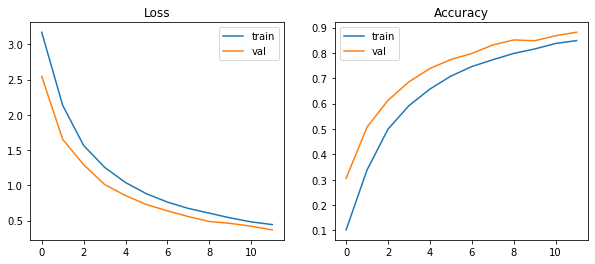

In [20]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(0, epochs), history.history['loss'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label='val')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(0, epochs), history.history['accuracy'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label='val')
plt.legend(loc='best')

In [42]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.38243367225699
Test accuracy: 0.8917450308799744


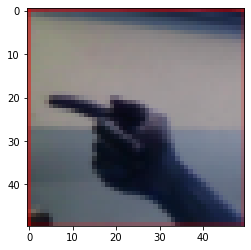

In [60]:
testImage = cv2.imread("../input/asl-alphabet/asl_alphabet_test/G_test.jpg")
resizedTestImage = processImageFile(testImage)
plt.imshow(resizedTestImage, cmap='gray')
plt.show()

In [61]:
y_predicted = model.predict(np.array([resizedTestImage]))
y_predicted_class = np.argmax(y_predicted, axis = 1) 

In [62]:
y_predicted_class[0]

6